In [1]:
#Import Libraries
import subprocess
import re
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
import seaborn as sns
import statsmodels.api as sm

from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table
from scipy import interp
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification


from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, LeaveOneOut, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dset_res=pd.read_csv("clintab_GMQL/miRNA/res_miRNA/res_miRNA_new.csv", delimiter='\t')

dset_res.head()
#dset_res.shape

,patient,chrom,start,stop,mirna_id,rpm,entrez_id,gene_symbol
0,R_00000,chr1,17368,17436,hsa-mir-6859-1,0.000000,102466751.0,mir6859-1
1,R_00000,chr1,30365,30503,hsa-mir-1302-2,0.000000,100302278.0,mir1302-2
2,R_00000,chr1,187890,187958,hsa-mir-6859-2,0.000000,102465909.0,mir6859-2
3,R_00000,chr1,632324,632413,hsa-mir-6723,0.000000,102465432.0,mir6723
4,R_00000,chr1,1167103,1167198,hsa-mir-200b,1010.337715,406984.0,mir200b


In [10]:
dset_senl=pd.read_csv("clintab_GMQL/miRNA/sl_miRNA_32/sl_miRNA_new.csv", delimiter='\t')
#dset_senl.head()

In [11]:
dset_sens=pd.read_csv("clintab_GMQL/miRNA/ss_miRNA_32/ss_miRNA_new.csv", delimiter='\t')
#dset_sens.head()

In [12]:
resdf=dset_res.pivot(index="patient", columns="mirna_id", values="rpm")
genes = resdf.columns.tolist()
resdf.shape

(60, 1881)

In [13]:
senldf=dset_senl.pivot(index="patient", columns="mirna_id", values="rpm")
senldf = senldf[genes]
senldf.shape

(34, 1881)

In [14]:
sensdf=dset_sens.pivot(index="patient", columns="mirna_id", values="rpm")
sensdf = sensdf[genes]
sensdf.shape

(107, 1881)

In [38]:
resdf_median = resdf.median(0)
senldf_median = senldf.median(0)
sensdf_median = sensdf.median(0)

In [39]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(senldf[gene],sensdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
    pvalues.append(gene_pvalue)
    
pvalues = pd.DataFrame({
    "gene": genes,
    #"resistant_median": resdf_median.values,
    "sensitive_long_median": senldf_median.values,
    "sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})
pvalues.head()

100%|██████████| 1881/1881 [00:00<00:00, 2964.44it/s]


,gene,sensitive_long_median,sensitive_short_median,mannwhiteney_pvalue
0,hsa-let-7a-1,24112.802719,26649.792598,0.081465
1,hsa-let-7a-2,24083.507960,26780.061935,0.081465
2,hsa-let-7a-3,24323.474442,26721.749378,0.079307
3,hsa-let-7b,73081.638557,79906.082243,0.069808
4,hsa-let-7c,13086.891246,16183.028840,0.176760


In [40]:
threshold = 0.005
#min_median_sum = 0

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()# & 
                            #(pvalues.resistant_median + pvalues.sensitive_long_median > min_median_sum)].copy()
#significant_genes["median_difference"] = (significant_genes.resistant_median - significant_genes.sensitive_long_median).abs()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])
significant_genes.head()

17


,gene,sensitive_long_median,sensitive_short_median,mannwhiteney_pvalue
1043,hsa-mir-4761,0.000000,0.000000,0.000293
149,hsa-mir-1301,126.137998,76.205448,0.000303
29,hsa-mir-1180,225.496917,153.256471,0.000343
1507,hsa-mir-6515,0.000000,0.000000,0.000665
244,hsa-mir-1912,0.000000,0.000000,0.000815


In [41]:
significant_genes.to_csv('giada/sl_ss_5_miRNA.csv', sep=',', header=True, index=False)

In [211]:
listageni=significant_genes['gene'].values
listageni

array(['hsa-mir-1301', 'hsa-mir-3200', 'hsa-mir-760', 'hsa-mir-219a-1',
       'hsa-mir-6509', 'hsa-mir-3607', 'hsa-mir-4746', 'hsa-mir-4758',
       'hsa-mir-23b', 'hsa-mir-877', 'hsa-mir-675', 'hsa-mir-296',
       'hsa-mir-1180', 'hsa-mir-200a', 'hsa-mir-652', 'hsa-mir-148b',
       'hsa-mir-29b-1', 'hsa-mir-500b', 'hsa-mir-128-2', 'hsa-mir-128-1',
       'hsa-mir-1287', 'hsa-mir-185', 'hsa-mir-429', 'hsa-mir-29a',
       'hsa-mir-106b', 'hsa-mir-1306', 'hsa-mir-502', 'hsa-mir-550a-1',
       'hsa-mir-1307', 'hsa-mir-183', 'hsa-mir-500a', 'hsa-mir-27b',
       'hsa-mir-181d', 'hsa-mir-224', 'hsa-mir-374b'], dtype=object)

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
/home/lalli/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


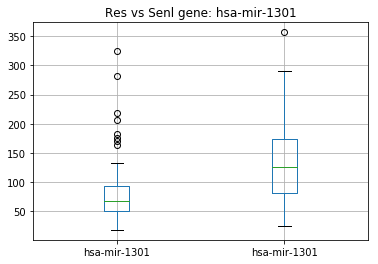

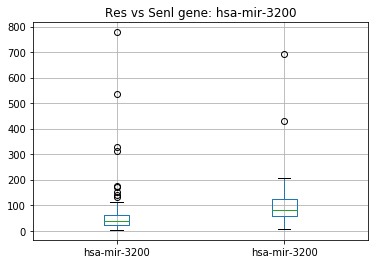

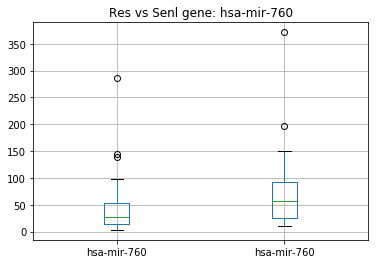

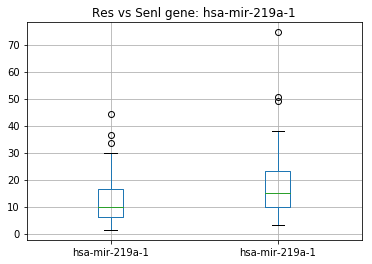

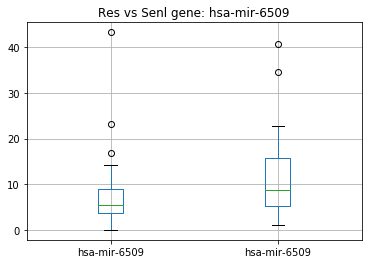

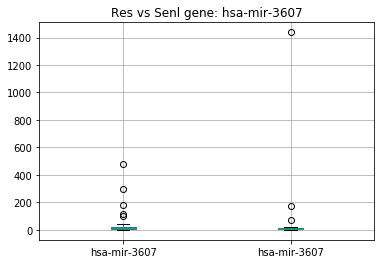

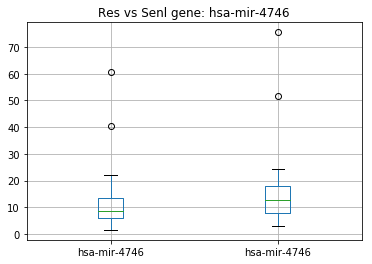

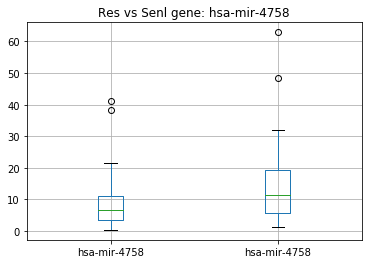

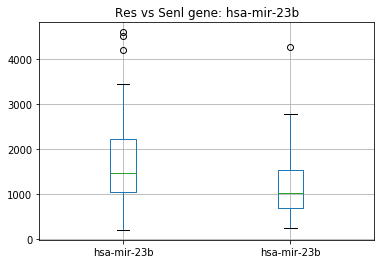

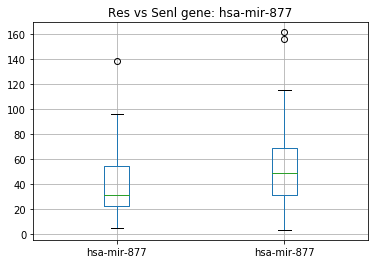

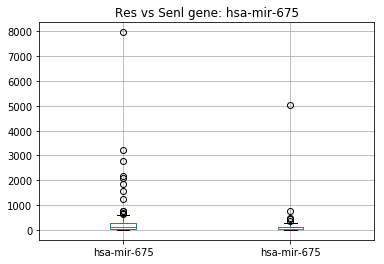

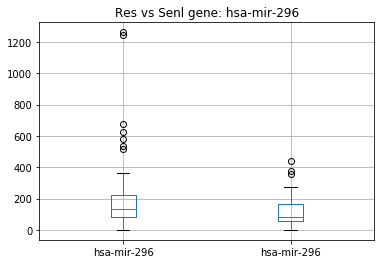

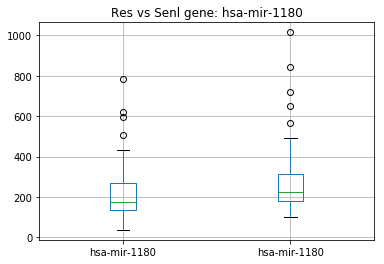

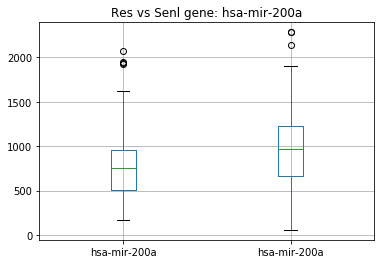

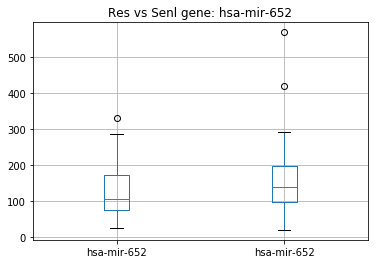

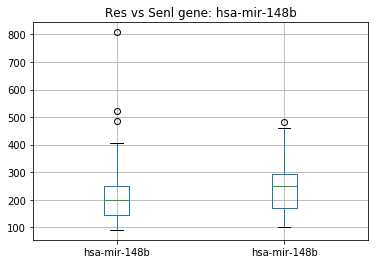

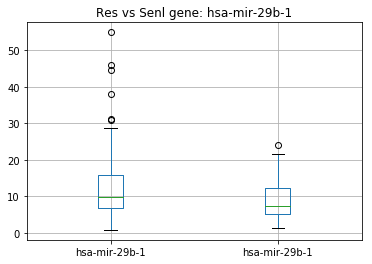

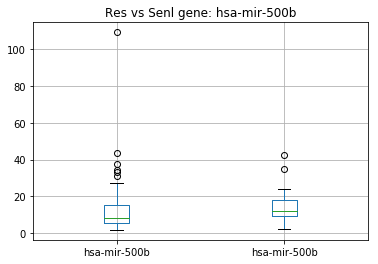

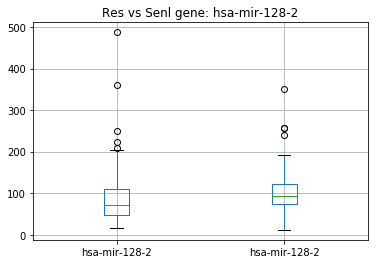

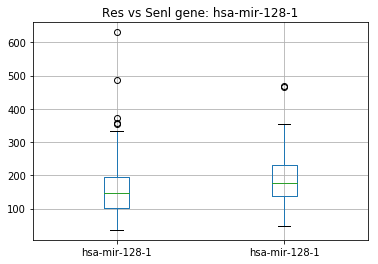

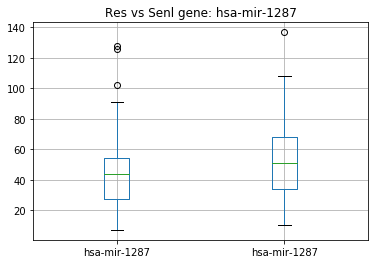

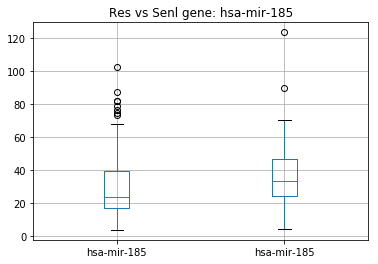

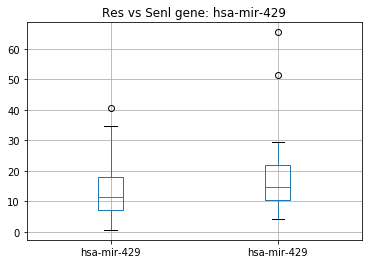

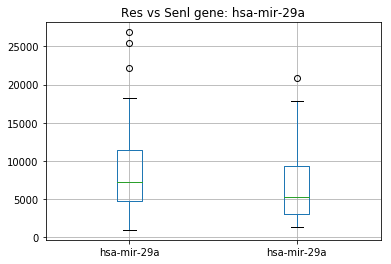

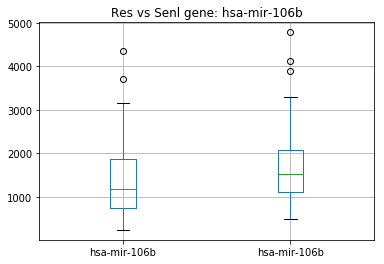

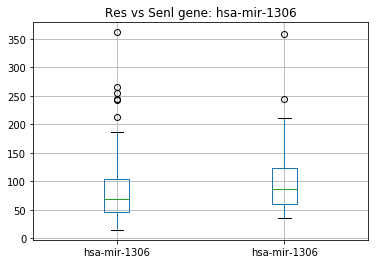

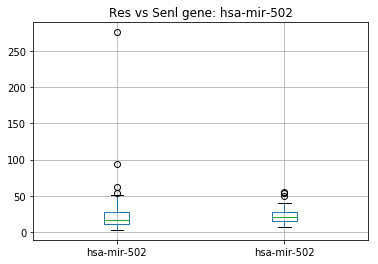

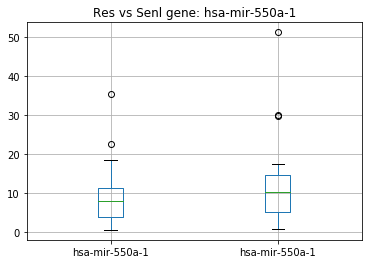

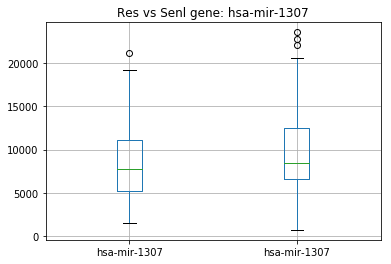

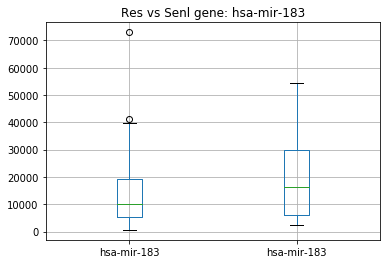

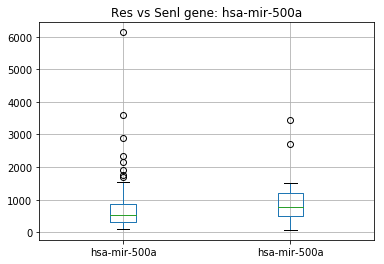

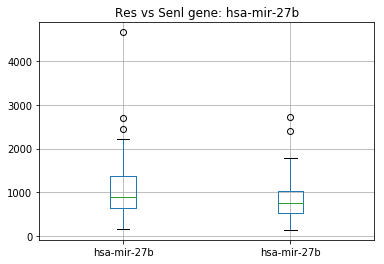

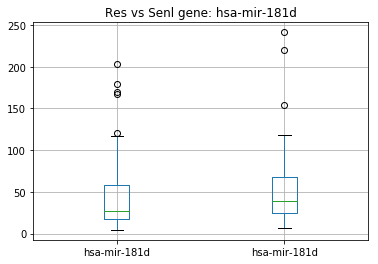

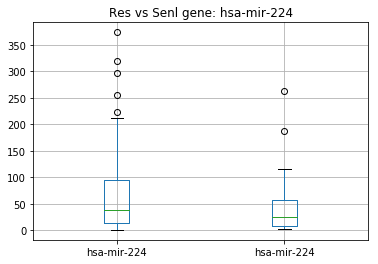

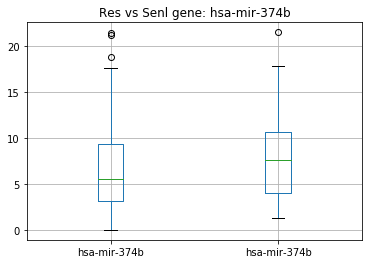

In [212]:
for g in listageni:

    boxplot1=pd.DataFrame(resdf, columns=[g])
    boxplot2=pd.DataFrame(senldf, columns=[g])
    fig, ax= plt.subplots()
    boxplot3=pd.concat([boxplot1, boxplot2], axis=1)
    ax.set_title('Res vs Senl gene: '+ g)

    boxplot_tot=boxplot3.boxplot()
    #plt.savefig('boxplot{}.png'.format(g))

/home/lalli/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


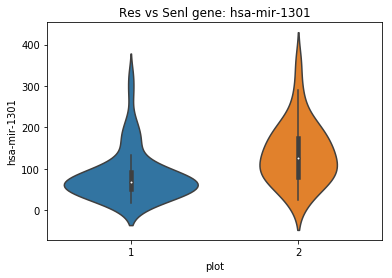

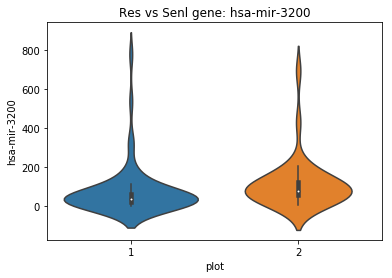

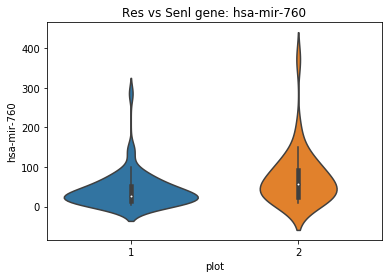

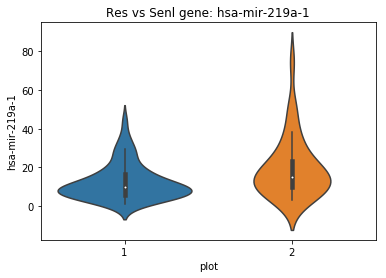

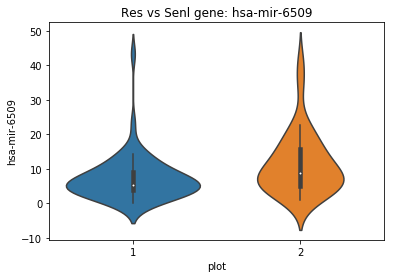

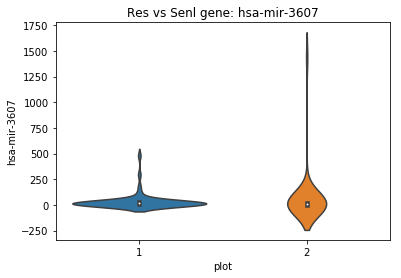

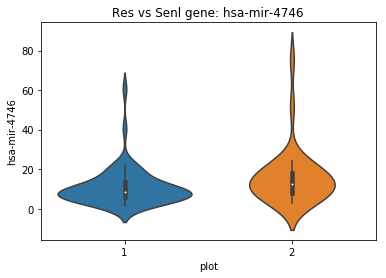

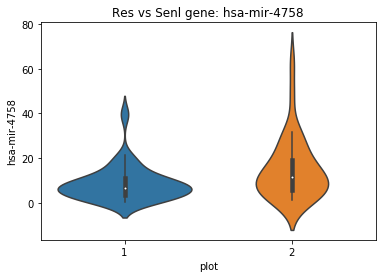

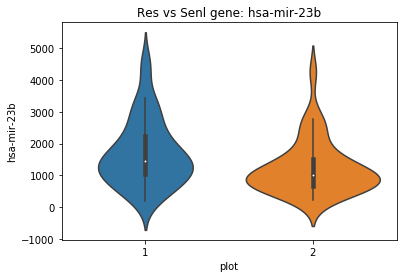

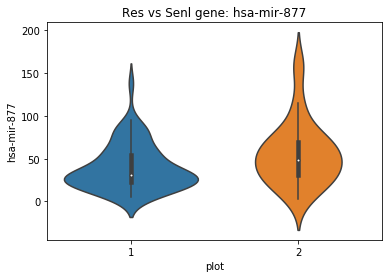

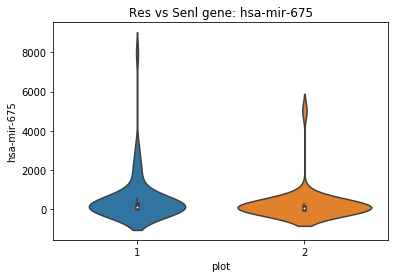

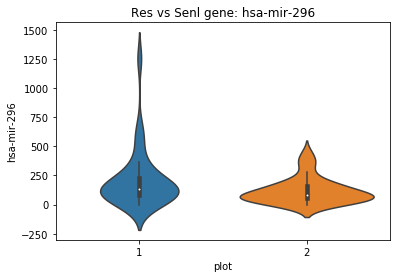

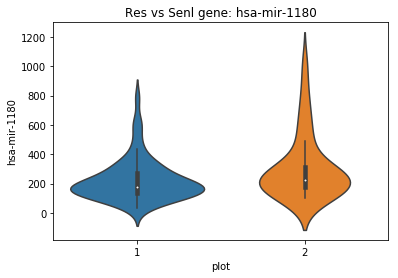

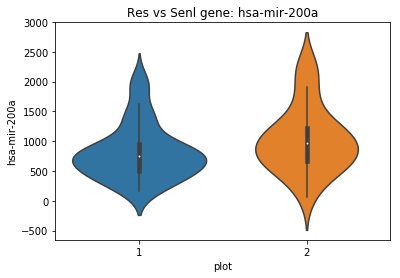

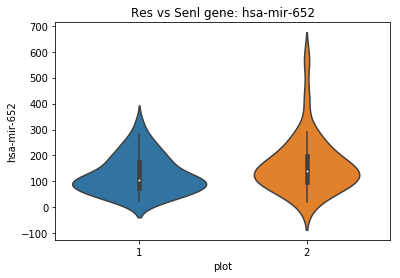

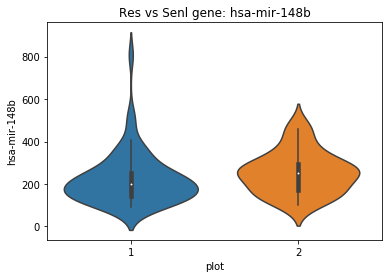

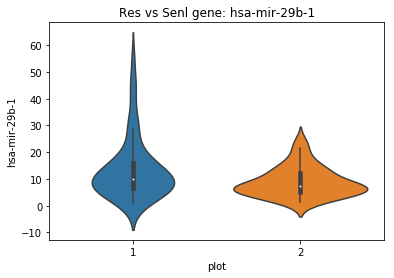

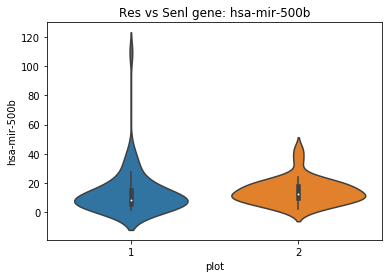

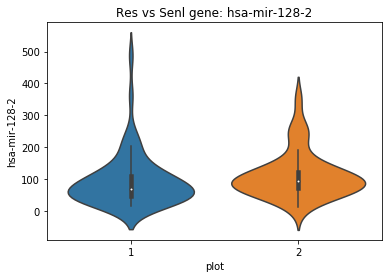

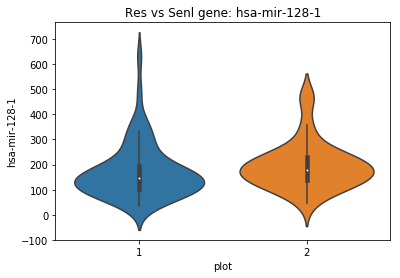

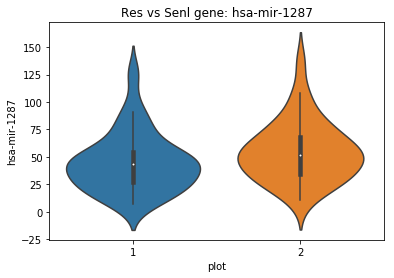

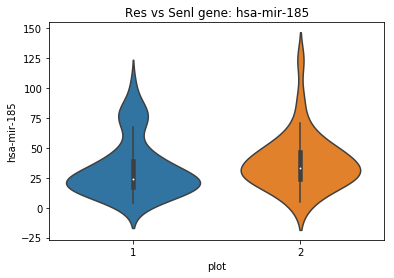

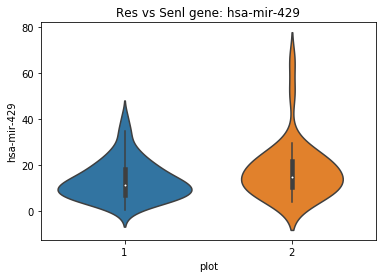

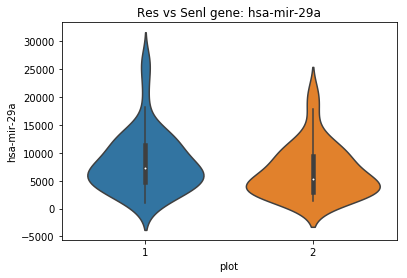

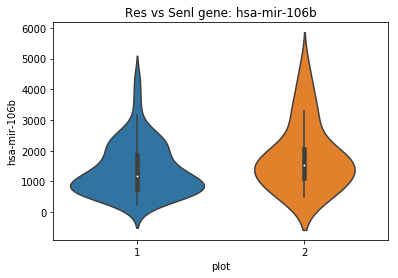

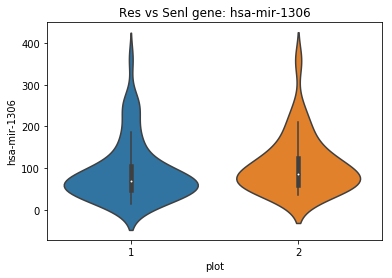

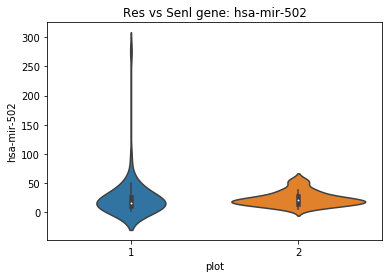

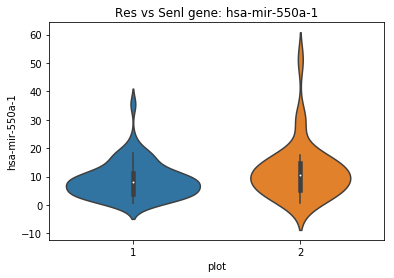

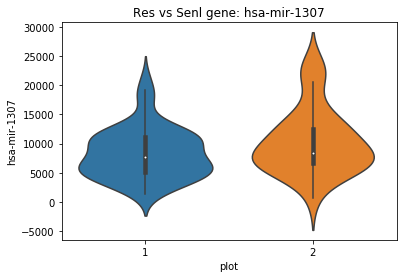

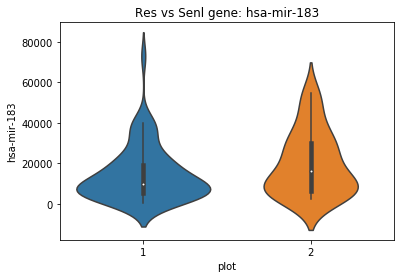

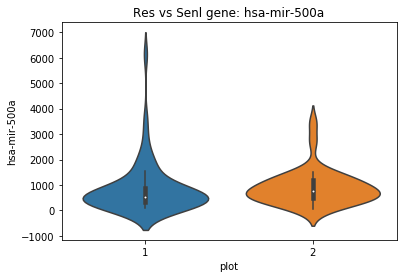

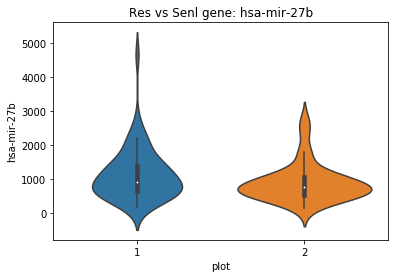

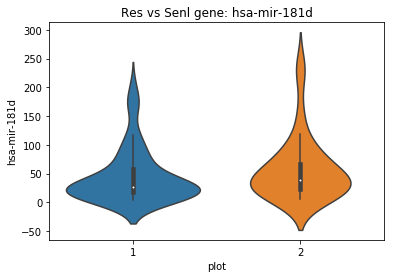

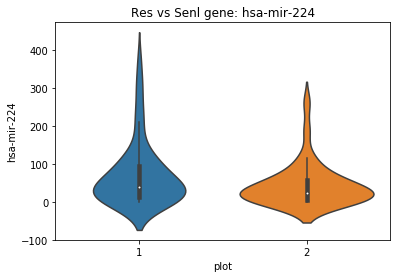

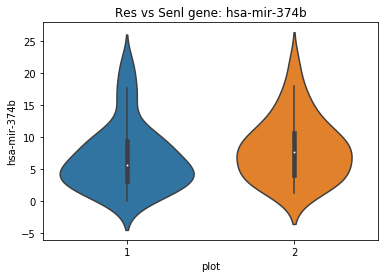

In [166]:
for g in listageni:

    boxplot1=pd.DataFrame(resdf, columns=[g])
    boxplot1['plot'] = 1
    boxplot2=pd.DataFrame(senldf, columns=[g])
    boxplot2['plot'] = 2
    
    fig, ax= plt.subplots()
    boxplot3=boxplot1.append(boxplot2)
    #print(boxplot3.head(5))
    #print(boxplot3.tail(5))
    
    ax.set_title('Res vs Senl gene: '+ g)

    boxplot_tot=sns.violinplot(data=boxplot3, y=g, x="plot", split=True)
    plt.savefig('violinplot{}.png'.format(g))

In [191]:
df1=pd.read_csv("miRNA_R_SenL.csv", delimiter=',')
df2=pd.read_csv("miRNA_R_SenS.csv", delimiter=',')
df3=pd.read_csv("miRNA_SenL_SenS.csv", delimiter=',')

In [185]:
lista1=pd.DataFrame(df1['gene'])
lista2=pd.DataFrame(df2['gene'])
lista3=pd.DataFrame(df3['gene'])

In [188]:
set(df1['gene'].unique()) & set(df2['gene'].unique()) & set(df3['gene'].unique())

{'hsa-mir-1180'}

In [192]:
lista_1=set(df1['gene'])
lista_2=set(df2['gene'])
lista_3=set(df3['gene'])

In [198]:
lista_1.intersection(lista_3)

{'hsa-mir-106b',
 'hsa-mir-1180',
 'hsa-mir-128-1',
 'hsa-mir-128-2',
 'hsa-mir-1301',
 'hsa-mir-1307',
 'hsa-mir-181d',
 'hsa-mir-183',
 'hsa-mir-185',
 'hsa-mir-200a',
 'hsa-mir-219a-1',
 'hsa-mir-224',
 'hsa-mir-23b',
 'hsa-mir-29a',
 'hsa-mir-29b-1',
 'hsa-mir-3200',
 'hsa-mir-3607',
 'hsa-mir-429',
 'hsa-mir-4746',
 'hsa-mir-4758',
 'hsa-mir-500a',
 'hsa-mir-500b',
 'hsa-mir-6509',
 'hsa-mir-675',
 'hsa-mir-760'}

In [208]:
concatenated=pd.concat([lista1, lista2, lista3])
tutti_geni=concatenated.drop_duplicates()
tutti_geni.head()

,gene
0,hsa-mir-1301
1,hsa-mir-3200
2,hsa-mir-760
3,hsa-mir-219a-1
4,hsa-mir-6509


In [6]:
dset_rna_sens=pd.read_csv("clintab_GMQL/sens_short_6_32/sens_short_6_32_rna_seq.csv", delimiter='\t')
#lista=set(dset_rna_res['ensemble_id'])
#dset_rna_sens.head()

In [7]:
dset_res = dset_rna_res[dset_rna_res.ensemble_id.isin(lista1)]
protein_coding_res=pd.DataFrame(dset_res)
protein_coding_res['genes'] = protein_coding_res['ensemble_id']+'-'+ protein_coding_res['gene_symbol']
#protein_coding_res.head()
#protein coding

In [8]:
dset_senl = dset_rna_senl[dset_rna_senl.ensemble_id.isin(lista1)]
protein_coding_senl=pd.DataFrame(dset_senl)
protein_coding_senl['genes'] = protein_coding_senl['ensemble_id']+'-'+ protein_coding_senl['gene_symbol']
#protein_coding_senl.head()

In [78]:
dset_sens = dset_rna_sens[dset_rna_sens.ensemble_id.isin(lista1)]
protein_coding_sens=pd.DataFrame(dset_sens)
protein_coding_sens['genes'] = protein_coding_sens['ensemble_id']+'-'+ protein_coding_sens['gene_symbol']
protein_coding_sens.head()

,patient,chrom,start,stop,ensemble_id,entrez_id,gene_symbol,fpkm_uq,fpkm,genes
8,SL_00000,chr1,69090,70008,ENSG00000186092.4,79501.0,OR4F5,0.000000,0.000000,ENSG00000186092.4-OR4F5
18,SL_00000,chr1,182392,184158,ENSG00000279928.1,NaN,FO538757.3,4240.671432,0.166236,ENSG00000279928.1-FO538757.3
19,SL_00000,chr1,184922,200322,ENSG00000279457.2,NaN,FO538757.2,47623.039719,1.866838,ENSG00000279457.2-FO538757.2
29,SL_00000,chr1,450739,451678,ENSG00000278566.1,729759.0,OR4F29,0.000000,0.000000,ENSG00000278566.1-OR4F29
49,SL_00000,chr1,685715,686654,ENSG00000273547.1,81399.0,OR4F16,0.000000,0.000000,ENSG00000273547.1-OR4F16


In [10]:
newdf = protein_coding_sens[['patient', 'genes', 'fpkm']]
sens=pd.DataFrame(newdf, columns=['patient', 'genes', 'fpkm'])
#sens.head()

In [77]:
newdf1 = protein_coding_senl[['patient', 'genes', 'fpkm']]
senl=pd.DataFrame(newdf1, columns=['patient', 'genes', 'fpkm'])
#senl.head()

,patient,genes,fpkm
8,SL_00000,ENSG00000186092.4-OR4F5,0.000000
18,SL_00000,ENSG00000279928.1-FO538757.3,0.295943
19,SL_00000,ENSG00000279457.2-FO538757.2,2.167993
29,SL_00000,ENSG00000278566.1-OR4F29,0.025143
49,SL_00000,ENSG00000273547.1-OR4F16,0.000000


In [12]:
newdf2 = protein_coding_res[['patient', 'genes', 'fpkm']]
res=pd.DataFrame(newdf2, columns=['patient', 'genes', 'fpkm'])
#res.head()
#res.dtypes

In [13]:
resdf=res.pivot(index="patient", columns="genes", values="fpkm")
#resdf.head()

In [14]:
senldf=senl.pivot(index="patient", columns="genes", values="fpkm")
senldf.head()

In [79]:
sensdf=sens.pivot(index="patient", columns="genes", values="fpkm")
sensdf.head()

genes,ENSG00000000003.13-TSPAN6,ENSG00000000005.5-TNMD,ENSG00000000419.11-DPM1,ENSG00000000457.12-SCYL3,ENSG00000000460.15-C1orf112,ENSG00000000938.11-FGR,ENSG00000000971.14-CFH,ENSG00000001036.12-FUCA2,ENSG00000001084.9-GCLC,ENSG00000001167.13-NFYA,...,ENSGR0000178605.11-GTPBP6,ENSGR0000182162.8-P2RY8,ENSGR0000182378.11-PLCXD1,ENSGR0000185291.9-IL3RA,ENSGR0000185960.11-SHOX,ENSGR0000196433.10-ASMT,ENSGR0000197976.9-AKAP17A,ENSGR0000198223.13-CSF2RA,ENSGR0000205755.9-CRLF2,ENSGR0000214717.8-ZBED1
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,11.155548,0.010591,41.292597,1.535906,1.334478,0.760769,2.394890,31.293801,3.114840,9.601552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SL_00001,9.970971,0.162765,26.897437,1.835926,1.498048,3.360918,4.582899,23.935597,2.363609,8.595218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SL_00002,15.431174,0.000000,30.882896,3.905040,0.809193,1.436212,45.235499,13.334574,2.388647,7.559635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SL_00003,28.942424,0.075746,55.930798,1.647744,1.640842,0.305905,6.908727,15.731159,3.975068,7.679924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SL_00004,11.692187,0.040912,33.572695,2.568514,1.088424,1.482703,6.890102,17.475291,2.780125,11.220616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
list_pv=[]


for g in (resdf.columns): 
    c1=resdf[g].values
    c2=senldf[g].values
    m1=np.median(c1)
    m2=np.median(c2)
    
    if m1==0.0 and m2==0.0:
        pass
    else:
    
        try: 

            #pv=scipy.stats.ttest_ind(c1,c2).pvalue
            pv=scipy.stats.mannwhitneyu(c1,c2).pvalue
            #pv=scipy.stats.wilcoxon(c1,c2).value
            if pv<0.001:
                list_pv.append((g,pv,m1,m2))
                #print(g,pv,m1,m2)

        except:
            pass

In [111]:
len(list_pv)

119

In [71]:
results=sorted(list_pv, key=lambda x:x[1])
len(results)


#for h in ["\t".join(map (str,list(x))) for x in results]:
     
dataset_result=pd.DataFrame(results)

In [72]:
dataset_result["sum"]=dataset_result[2]+dataset_result[3]
new_ds=dataset_result[dataset_result["sum"]>10]
#new_ds.shape
new_ds.columns=['ensemble_id', 'p_value', 'median_SenL', 'median_SenS', 'sum']

#ax = plt.subplot(111, frame_on=False) # no visible frame
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)  # hide the y axis

#table(ax, new_ds)  # where df is your data frame

#plt.savefig('mytable.png')

In [73]:
names=[]

for x in ["-".join(x.strip().split("-")[1:])  for x in (new_ds['ensemble_id'])]:
    names.append(x)   

In [104]:
new_ds['gene_symbol']=names
#new_ds.to_csv('geni_SenL_SenS.csv', sep=',', header=True, index=False)
new_ds

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ensemble_id,p_value,median_SenL,median_SenS,sum,gene_symbol
1,ENSG00000137393.9-RNF144B,0.000065,8.484803,15.532160,24.016963,RNF144B
2,ENSG00000134504.11-KCTD1,0.000086,6.369336,10.695657,17.064993,KCTD1
4,ENSG00000137364.4-TPMT,0.000117,10.070143,13.108867,23.179010,TPMT
8,ENSG00000090520.9-DNAJB11,0.000196,12.506819,18.471290,30.978109,DNAJB11
11,ENSG00000177383.4-MAGEF1,0.000228,40.393938,66.782924,107.176862,MAGEF1
13,ENSG00000276180.1-HIST1H4I,0.000305,15.411832,24.353926,39.765757,HIST1H4I
14,ENSG00000143013.11-LMO4,0.000314,22.308994,32.975951,55.284945,LMO4
15,ENSG00000119888.9-EPCAM,0.000363,134.597634,166.623280,301.220914,EPCAM
16,ENSG00000085276.16-MECOM,0.000373,10.360971,16.540886,26.901857,MECOM
17,ENSG00000124659.6-TBCC,0.000373,21.169336,27.833890,49.003226,TBCC


In [75]:
listageni=new_ds['ensemble_id'].values
listageni

array(['ENSG00000137393.9-RNF144B', 'ENSG00000134504.11-KCTD1',
       'ENSG00000137364.4-TPMT', 'ENSG00000090520.9-DNAJB11',
       'ENSG00000177383.4-MAGEF1', 'ENSG00000276180.1-HIST1H4I',
       'ENSG00000143013.11-LMO4', 'ENSG00000119888.9-EPCAM',
       'ENSG00000085276.16-MECOM', 'ENSG00000124659.6-TBCC',
       'ENSG00000155660.9-PDIA4', 'ENSG00000197903.7-HIST1H2BK',
       'ENSG00000114315.3-HES1', 'ENSG00000106144.18-CASP2',
       'ENSG00000008952.15-SEC62', 'ENSG00000073803.12-MAP3K13',
       'ENSG00000139629.14-GALNT6', 'ENSG00000071967.10-CYBRD1',
       'ENSG00000198162.11-MAN1A2', 'ENSG00000105825.10-TFPI2',
       'ENSG00000156298.11-TSPAN7', 'ENSG00000197323.9-TRIM33',
       'ENSG00000060339.12-CCAR1', 'ENSG00000105875.12-WDR91',
       'ENSG00000055130.14-CUL1'], dtype=object)

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
/home/lalli/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


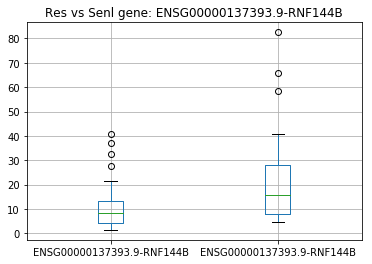

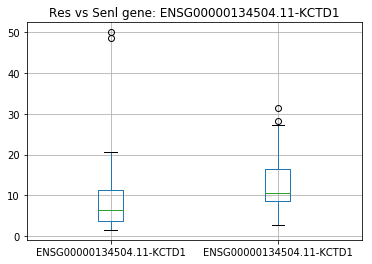

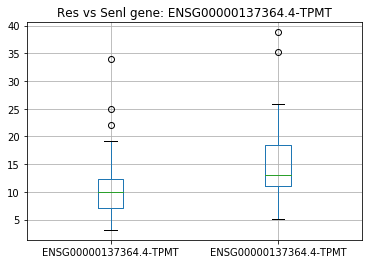

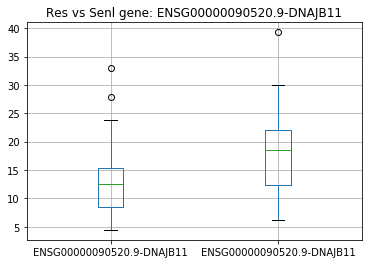

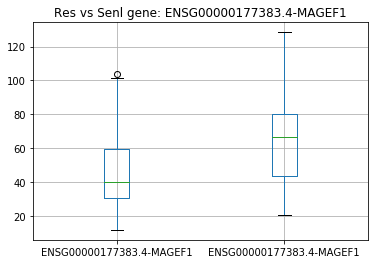

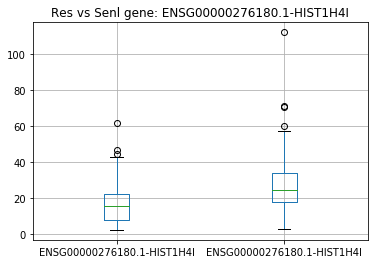

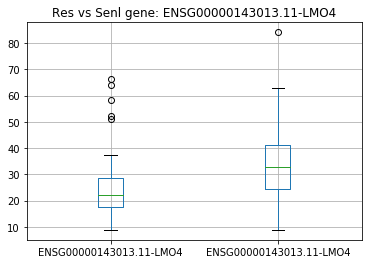

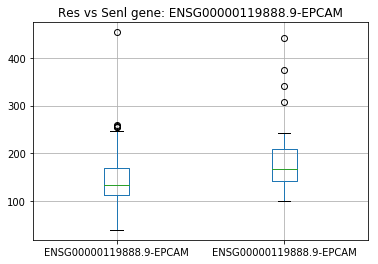

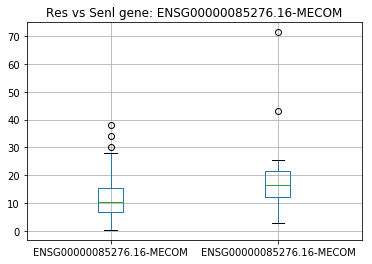

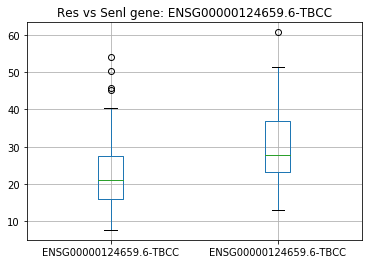

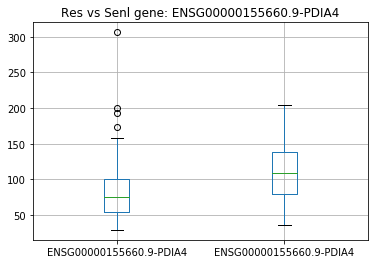

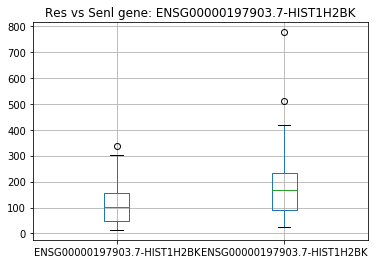

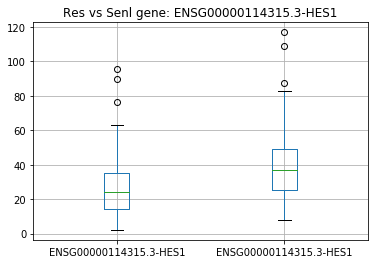

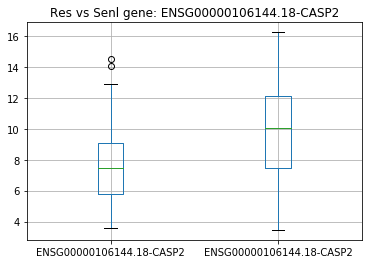

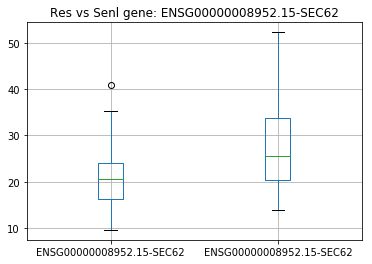

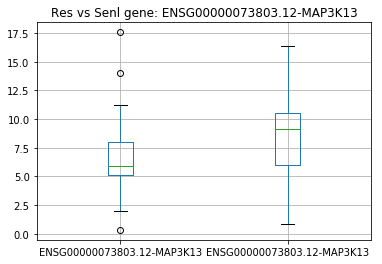

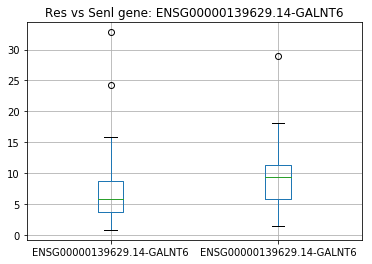

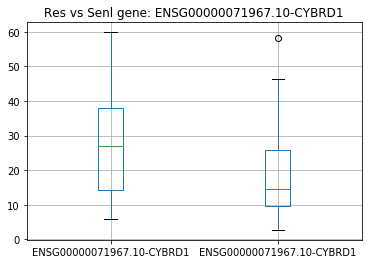

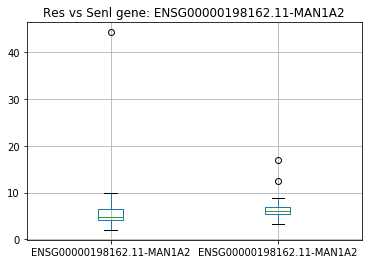

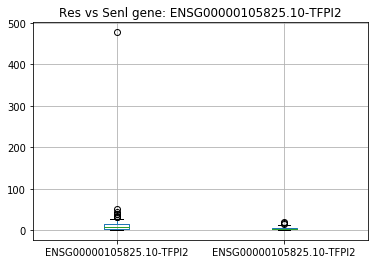

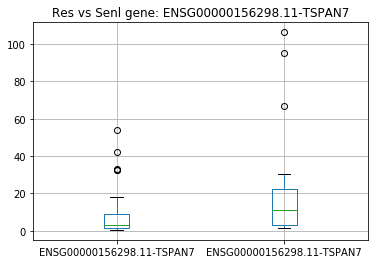

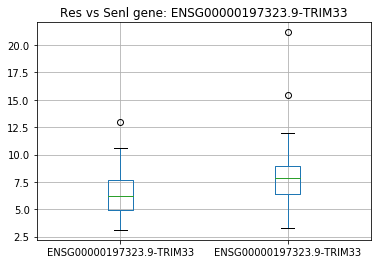

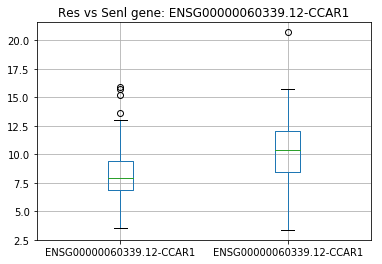

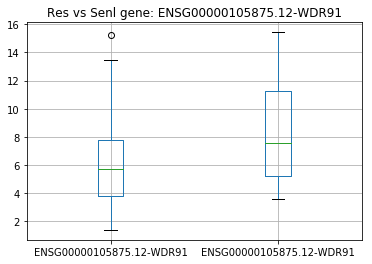

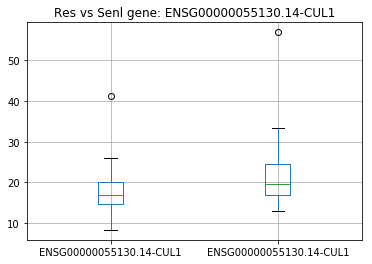

In [76]:
for g in listageni:

    boxplot1=pd.DataFrame(resdf, columns=[g])
    boxplot2=pd.DataFrame(senldf, columns=[g])
    fig, ax= plt.subplots()
    boxplot3=pd.concat([boxplot1, boxplot2], axis=1)
    ax.set_title('Res vs Senl gene: '+ g)

    boxplot_tot=boxplot3.boxplot()
    #plt.savefig('boxplot{}.png'.format(g))

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



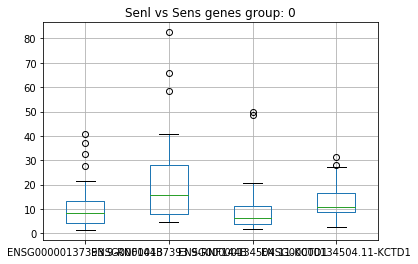

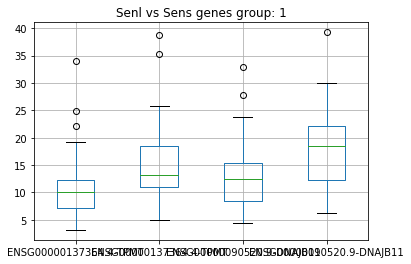

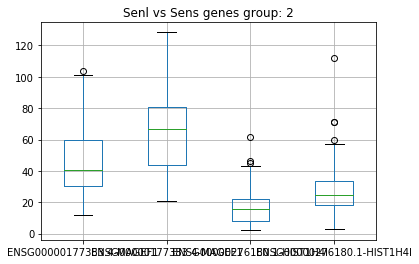

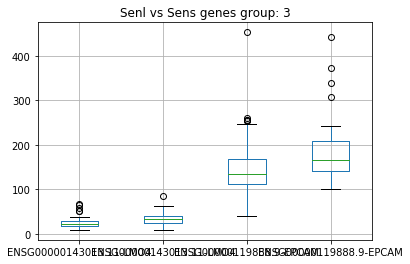

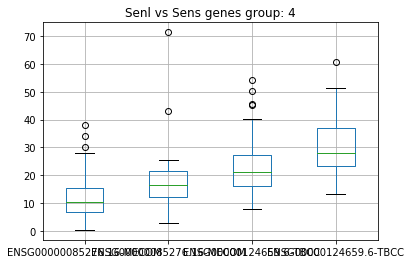

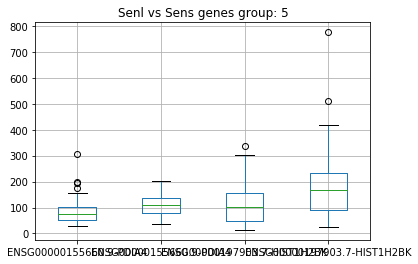

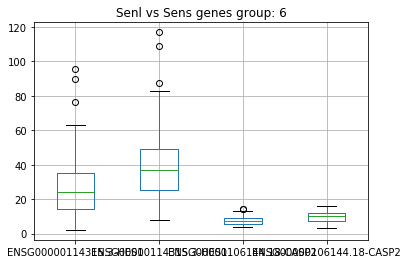

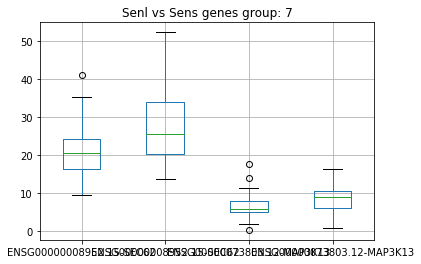

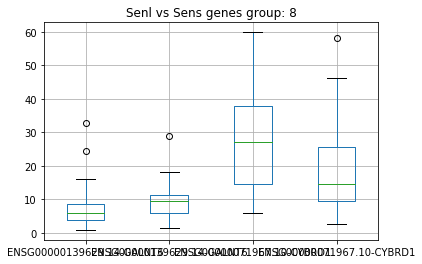

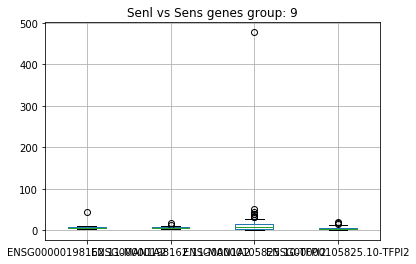

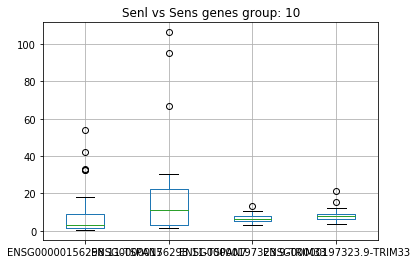

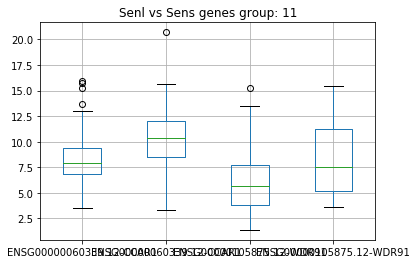

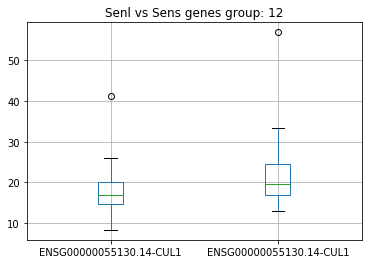

In [105]:
#from numpy.core.defchararray import add
n = 2
geni_splitted = [listageni[i:i+n] for i in range(0, len(listageni), n)]
for i, group in enumerate(geni_splitted):
    
    fig, ax= plt.subplots()
    ax.set_title('Senl vs Sens genes group: '+ str(i))
    #labels_res = add(group, '_res')
    #labels_senl = add(group, '_senl')
    #labels = np.empty((labels_senl.size + labels_res.size,), dtype=labels_res.dtype)
    #labels[0::2] = labels_res
    #labels[1::2] = labels_senl
    
    for j, g in enumerate(group):
        boxplot1=pd.DataFrame(resdf, columns=[g])
        boxplot2=pd.DataFrame(senldf, columns=[g])
        
        if j == 0:
            boxplot_total=pd.concat([boxplot1, boxplot2], axis=1)
        else:
            boxplot_total=pd.concat([boxplot_total, boxplot1, boxplot2], axis=1)
    #plt.xticks(len(labels), labels, rotation='vertical')
    boxplot_total.boxplot()
    #plt.savefig('boxplot_total{}.png'.format(g))

In [ ]:
dataset_result

In [ ]:
column=(dataset_result[0])

In [ ]:
senl_selected=senldf[column]
senl_selected["label"]=1
senl_selected.shape

In [ ]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

In [ ]:
#concatenated=pd.concat([res_selected, senl_selected])
#concatenated=pd.concat([res_selected, sens_selected])
concatenated=pd.concat([senl_selected, sens_selected])

In [ ]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [ ]:
#kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_sen', 'false_res', 'true_res', 'false_sen', 'accuracy', 'precision', 'recall']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    #clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sen']=c_matrix[0][0]
    performance.iloc[i]['false_sen']=c_matrix[1][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    print (i)
    i=i+1
    

In [ ]:
# ROC curve
#classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#classifier = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
classifier = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#classifier=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#classifier= LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve SenL vs SenS')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
#plt.savefig('ROC_Res_vs_SenL_RF.png')

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
y_real = []
y_proba = []
#predictor= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
predictor = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#predictor = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#predictor = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Res vs Senl')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('ROC_Res_vs_SenS.png')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thr = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
#plt.show()
plt.title('PR curve Res vs SenS')
#plt.savefig('PR curve Res vs Senl_RF.png')